<a href="https://www.kaggle.com/code/carlosdrebollar/titanic-project?scriptVersionId=157155532" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
from sklearn.model_selection import train_test_split # train/validation splits
from sklearn.impute import KNNImputer, SimpleImputer # imputers 

# Load data
train_df = pd.read_csv("/kaggle/input/titanic-machine-learning-from-disaster/train.csv")

# View head of training data
train_df.head()

# Analyze missing values
train_df.isna().sum(axis = 0) # Age: 177, Cabin: 687, Embarked: 2

# Removed 2 obs w/ missing "Embarked"
train_df = train_df.dropna(subset = 'Embarked') 
train_df.shape # 889 observations, 12 variables

# Add "Cabin" and "Age" missing indicator
train_df["Cabin_NA"] = train_df["Cabin"].isna()
train_df["Age_NA"] = train_df["Age"].isna()

# Add "Alone" indicator
train_df["Alone"] = train_df[["SibSp", "Parch"]].sum(axis = 1) == 0

# Add "Adult_male" indicator
train_df["Adult_male"] = (train_df["Age"] >= 18) & (train_df["Sex"] == "male")

# Define a regular expression to extract the prefix and number
regex_pattern = r'(?P<ticket_prefix>.*?)(?P<ticket_number>\d+)$'

# Use str.extract to create new columns
train_df = pd.merge(train_df, train_df['Ticket'].str.extract(regex_pattern), left_index = True, right_index = True)
train_df['ticket_prefix'] = train_df['ticket_prefix'].replace("", 'NA').str.replace(".", "")
train_df['ticket_prefix'] = train_df['ticket_prefix'].str.replace(" ", "").str[:1]

# Extracting title into a new column
train_df["Name_title"] = train_df["Name"].str.split(',').str[1].str.strip().str.split(' ').str[0]

# List of valid titles
valid_titles = ['Mrs.', 'Mr.', 'Master.', 'Miss.']

# Replace titles not in the valid list with 'Other'
train_df["Name_title"] = train_df["Name_title"].apply(lambda x: x if x in valid_titles else 'Other')

# Calculate the median age for each title
median_age_by_title = train_df.groupby('Name_title')['Age'].transform('median')

# Fill missing values in 'Age' with the corresponding median for each title
train_df["Age_IMP"] = train_df['Age'].fillna(median_age_by_title)

# Define initial data sets
X = train_df.drop(["Survived", "PassengerId", "Name", "Cabin", "Ticket", "ticket_number", "Age"], axis = 1)
y = train_df.Survived

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .15, random_state = 42)

# Get dummies
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)

print(X_train.columns)

# Initialize KNN imputer
knn_imputer = KNNImputer()
knn_imputer.fit(X_train)

# Initialize simple median imputer
median_imputer = SimpleImputer(strategy = 'median')
median_imputer.fit(X_train)

# Impute Age with median imputer for training and validation
X_train_imp = pd.DataFrame(median_imputer.transform(X_train), columns = X_train.columns.tolist())
X_valid_imp = pd.DataFrame(median_imputer.transform(X_valid), columns = X_valid.columns.tolist())

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Cabin_NA', 'Age_NA', 'Alone',
       'Adult_male', 'Age_IMP', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'ticket_prefix_A', 'ticket_prefix_C',
       'ticket_prefix_F', 'ticket_prefix_N', 'ticket_prefix_P',
       'ticket_prefix_S', 'ticket_prefix_W', 'Name_title_Master.',
       'Name_title_Miss.', 'Name_title_Mr.', 'Name_title_Mrs.',
       'Name_title_Other'],
      dtype='object')


# Logistic Regression
## Validation Accuracy = 85.82%
### Data preparation

In [278]:
def LogPrep(input_dat):
    
    dat = input_dat.copy()

    dat["Pclass"] = dat["Pclass"].astype("category")

    # Only 15 with "Parch" >= 3. Change to categorical
    dat["Parch"] = dat["Parch"].apply(lambda x: 3 if x >= 3 else x).astype(str)
    dat["Parch"] = dat["Parch"].replace("3", "3 or greater").astype("category")

    # Only 12 with "SibSp" >= 5. Change to categorical
    dat["SibSp"] = dat["SibSp"].apply(lambda x: 5 if x >= 5 else x).astype(str)
    dat["SibSp"] = dat["SibSp"].replace("5", "5 or greater").astype("category")
    
    dat = dat.drop(["Sex_female", "Embarked_C"], axis = 1)
    dat = pd.get_dummies(dat, drop_first = True)
    
    return(dat)

### Model Fitting

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Prepare training and validation data
X_train_imp_lr = LogPrep(X_train_imp)
X_valid_imp_lr = LogPrep(X_valid_imp)

# Create a Logistic Regression model
logreg_model = LogisticRegression(max_iter = 2000, random_state = 42)

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv = 5, scoring = 'roc_auc')

# Fit the model to the training data
grid_search.fit(X_train_imp_lr, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Average AUC Score:", round(100 * grid_search.best_score_, 2))

# Store the best model
best_logreg_model = grid_search.best_estimator_

# Make predictions on the training set to get predicted probabilities
y_pred_proba = best_logreg_model.predict_proba(X_train_imp_lr)[:, 1]

# Calculate AUC on training: 86.57%
auc_score = roc_auc_score(y_train, y_pred_proba)
print("Training AUC:", round(100 * auc_score, 2))

# Make predictions on the validation set to get predicted probabilities
y_pred_proba_valid = best_logreg_model.predict_proba(X_valid_imp_lr)[:, 1]

# Calculate AUC on validation: 88.26%
auc_score_valid = roc_auc_score(y_valid, y_pred_proba_valid)
print("Validation AUC:", round(100 * auc_score_valid, 2))

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Average AUC Score: 86.7
Training AUC: 87.82
Validation AUC: 88.26


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

### Determine the cutoff that maximized the accuracy

In [148]:
from sklearn.metrics import accuracy_score

lr_results = pd.DataFrame()
lr_results['p_hat'] = best_logreg_model.predict_proba(X_train_imp_lr)[:, 1]

accuracy = np.array([])

for cutoff in range(100):
  lr_results["pred"] = lr_results['p_hat'].map(lambda x: 1 if x > (cutoff / 100) else 0)
  value_a = accuracy_score(y_train, lr_results["pred"])
  accuracy = np.append(accuracy, value_a)

data = {'Accuracy': accuracy, 'Cut-off': range(100)}
acc_s = pd.DataFrame(data)

# Retrieve cutoff that maximizes accuracy
optimal_cutoff = acc_s.sort_values(by = ['Accuracy'], ascending = False).iloc[0][1]/100
print(optimal_cutoff)

0.61


### Determine accuracy on validation set

In [172]:
from sklearn.metrics import accuracy_score

# Make predictions on the validation set to get predicted probabilities
y_prob_valid_lr = best_logreg_model.predict_proba(X_valid_imp_lr)[:,1]
y_pred_valid_lr = y_prob_valid_lr >= optimal_cutoff

accuracy_lr = accuracy_score(y_valid, y_pred_valid_lr)
print("Accuracy:", round(100 * accuracy_lr, 2)) # Accuracy of 81.46% on validation set.

Accuracy: 85.82


# Tree-Based Methods
## Decision Tree 
### Cross-validated accuracy on training = 82.65%
### Validation Accuracy = 81.34%

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state = 42)

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv = 5, scoring = 'accuracy')

# Fit the model to the training data
grid_search.fit(X_train_imp, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best accuracy score found (on training)
print("Best cross-validated training accuracy:", round(100 * grid_search.best_score_, 2))

# Store best model
best_dt_model = grid_search.best_estimator_

# Store validation predictions
y_pred_valid_dt = best_dt_model.predict(X_valid_imp)

# Evaluate the model's performance
accuracy_dt = best_dt_model.score(X_valid_imp, y_valid) * 100
print("Accuracy:", round(accuracy_dt, 2)) # Accuracy of 81.46% on validation set.

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best cross-validated training accuracy: 82.65
Accuracy: 81.34


## Random Forest
### Mean training accuracy in cross-validation = 83.05%
### Validation accuracy = 84.33%

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state = 42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 9, 10, 11],
    'min_samples_split': [9, 10, 11],
    'min_samples_leaf': [2, 3, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv = 5, scoring = 'accuracy')

# Fit the model to the training data
grid_search.fit(X_train_imp, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best accuracy score found (on training)
print("Best cross-validated training accuracy:", round(100 * grid_search.best_score_, 2))

# Store the best model
best_rf_model = grid_search.best_estimator_

# Store validation predictions
y_pred_valid_rf = best_rf_model.predict(X_valid_imp)
y_prob_valid_rf = best_rf_model.predict_proba(X_valid_imp)[:,1]


# Evaluate the model's performance
accuracy_rf = best_rf_model.score(X_valid_imp, y_valid) * 100
print("Accuracy:", round(accuracy_rf, 2)) # Display accuracy on the validation set

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 100}
Best cross-validated training accuracy: 83.18
Accuracy: 84.33


## XGBoost Classifier 
### Mean training accuracy in cross-validation = 83.71%
### Validation accuracy = 79.85%

In [161]:
from xgboost import XGBClassifier

# Create an XGBClassifier
xgb_classifier = XGBClassifier(random_state = 42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [13, 14, 15],  # Number of boosting rounds
    'learning_rate': [.1, .2, .3],
    'max_depth': [9, 10, 11],
    'subsample': [.5, .6, .7],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_classifier, param_grid, cv = 5, scoring = 'accuracy')

# Fit the model to the training data
grid_search.fit(X_train_imp, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best accuracy score found (on training)
print("Best cross-validated training accuracy:", round(100 * grid_search.best_score_, 2))

# Store the best model
best_xgb_model = grid_search.best_estimator_

# Store validation predictions
y_pred_valid_xgb = best_xgb_model.predict(X_valid_imp)
y_prob_valid_xgb = best_xgb_model.predict_proba(X_valid_imp)[:,1]

# Evaluate the model's performance
accuracy_xgb = best_xgb_model.score(X_valid_imp, y_valid) * 100
print("Accuracy:", round(accuracy_xgb, 2))  # Display accuracy on the validation set

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 14, 'subsample': 0.6}
Best cross-validated training accuracy: 83.71
Accuracy: 79.85


# Naive Bayes
### Mean training accuracy in cross-validation = 80.26%
### Validation accuracy = 81.34%

In [152]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb_classifier = GaussianNB()

# Define the hyperparameter grid
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator = gnb_classifier, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train_imp, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Store the best model
best_gnb_model = grid_search.best_estimator_

# Store validation predictions
y_pred_valid_gnb = best_gnb_model.predict(X_valid_imp)

accuracy_nb = accuracy_score(y_valid, y_pred_valid_gnb)
print("Validation accuracy:", round(100 * accuracy_nb, 2))

Best Parameters:  {'var_smoothing': 1e-05}
Best Accuracy:  0.8026490066225165
Validation accuracy: 81.34


In [216]:
y_prob_valid_gnb = best_gnb_model.predict_proba(X_valid_imp)[:,1]
y_prob_valid_gnb

array([1.56108244e-04, 9.99999241e-01, 9.99785233e-01, 3.18816728e-04,
       9.99991767e-01, 1.58843997e-04, 3.41206180e-04, 1.74586591e-04,
       9.99999989e-01, 9.99999935e-01, 2.99977758e-03, 9.99460582e-01,
       1.48828492e-04, 3.66314184e-03, 1.53280901e-04, 7.11363173e-05,
       9.96491390e-01, 5.33281912e-03, 3.61798264e-03, 4.80104945e-04,
       2.03024371e-04, 9.99996557e-01, 3.72784141e-04, 7.38694799e-01,
       2.83512833e-08, 9.93645710e-01, 1.07641677e-02, 9.99647267e-01,
       4.26895595e-03, 3.37125134e-04, 1.11643960e-02, 9.93310860e-01,
       1.69658943e-04, 1.11734221e-01, 1.54473853e-04, 3.03119244e-02,
       9.99405728e-01, 1.00000000e+00, 5.30190160e-03, 2.83512833e-08,
       3.16362068e-04, 9.91615589e-01, 3.52924714e-04, 1.60530152e-04,
       1.04720489e-03, 9.77208107e-02, 9.99924348e-01, 5.88018150e-05,
       3.07152011e-04, 1.00000000e+00, 9.99365180e-01, 9.97091459e-01,
       1.71817384e-04, 6.54311198e-04, 9.99135630e-01, 9.97482583e-01,
      

# KNN Classifier
### Mean training accuracy in cross-validation = 82.38%
### Validation accuracy = 82.84%

    k_values   scores
13        14  0.82382
Validation accuracy: 82.84


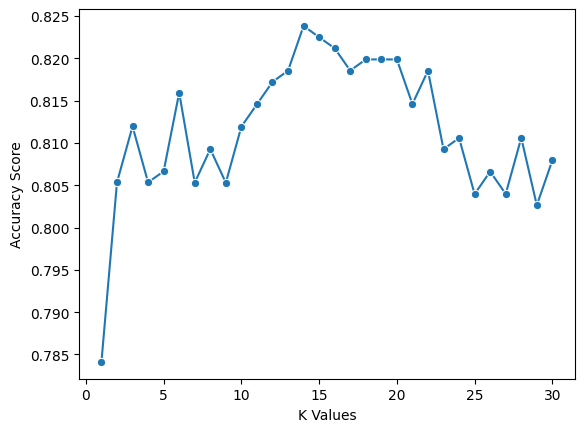

In [153]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the features using StandardScaler
scaler = StandardScaler().fit(X_train_imp)
X_train_knn = scaler.transform(X_train_imp)
X_valid_knn = scaler.transform(X_valid_imp)

# Cross validation to get best value of K
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X_train_knn, y_train, cv = 6)
    scores.append(np.mean(score))
    
knn_dat = pd.DataFrame({"k_values": k_values, "scores": scores}) 

# Plot results
sns.lineplot(x = k_values, y = knn_dat["scores"], marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

# Extract best k
print(knn_dat.sort_values("scores", ascending = False).head(1))
best_k = knn_dat.sort_values("scores", ascending = False).iloc[0]['k_values']

# Instantiate and fit the model
knn = KNeighborsClassifier(n_neighbors = int(best_k))
knn.fit(X_train_knn, y_train)

# Store validation predictions
y_pred_valid_knn = knn.predict(X_valid_knn)
y_prob_valid_knn = knn.predict_proba(X_valid_knn)[:,1]

# Accuracy
accuracy_knn = accuracy_score(y_valid, y_pred_valid_knn)
print("Validation accuracy:", round(100 * accuracy_knn , 2))

In [198]:
y_prob_valid_knn = knn.predict_proba(X_valid_knn)[:,1]

# Neural Nets
## Sequential Model (Validation accuracy = 85.82%)

In [244]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale the features using StandardScaler
scaler = StandardScaler().fit(X_train_imp)
X_train_nn = scaler.transform(X_train_imp)
X_valid_nn = scaler.transform(X_valid_imp)

# Build the neural network model
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_dim = X_train_nn.shape[1]))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
model.fit(X_train_nn, y_train, epochs = 10, batch_size = 32, validation_data = (X_valid_nn, y_valid))

# Store validation predictions
y_prob_valid_seq = model.predict(X_valid_nn)
y_pred_valid_seq = y_prob_valid_seq > .5

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_valid_nn, y_valid)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/10
24/24 [==============================] - 1s 12ms/step - loss: 0.6504 - accuracy: 0.5987 - val_loss: 0.5136 - val_accuracy: 0.8433
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.8013 - val_loss: 0.4273 - val_accuracy: 0.8582
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4414 - accuracy: 0.8093 - val_loss: 0.4024 - val_accuracy: 0.8657
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4253 - accuracy: 0.8159 - val_loss: 0.3932 - val_accuracy: 0.8582
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4145 - accuracy: 0.8238 - val_loss: 0.3860 - val_accuracy: 0.8657
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8371 - val_loss: 0.3840 - val_accuracy: 0.8657
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 0.8397 - val_loss: 0.3820 - val_accuracy: 0.8657
Epoch 8/10
24/24 [=

## MLP Classifier
### Mean training accuracy in cross-validation = 82.12%
### Validation accuracy = 79.85%

In [237]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [3, 4, 5, 6],
    'alpha': [0.00005, 0.0005, .005],
    'solver': ['lbfgs']
}

mlp_model = MLPClassifier(max_iter = 5000, random_state = 12345)

# Train the model
grid_search = GridSearchCV(mlp_model, param_grid = param_grid, cv = 5)
grid_search.fit(X_train_nn, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Store the best model
best_gnb_model = grid_search.best_estimator_

# Store validation predictions
y_pred_valid_mlp = best_gnb_model.predict(X_valid_knn)
y_prob_valid_mlp = best_gnb_model.predict_proba(X_valid_knn)[:,1]

# Accuracy
accuracy_mlp = accuracy_score(y_valid, y_pred_valid_mlp)
print("Validation accuracy:", round(100 * accuracy_mlp , 2))

Best Parameters:  {'alpha': 0.0005, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
Best Accuracy:  0.8211920529801325
Validation accuracy: 79.85


# Ensemble Predictions (Validation Accuracy = 84.33%)

In [296]:
ensemble = y_valid.to_frame().reset_index()
#ensemble['logistic_reg'] = y_pred_valid_lr
#ensemble['decision_tree'] = y_pred_valid_dt
#ensemble['random_forest'] = y_pred_valid_rf
#ensemble['xgboost'] = y_pred_valid_xgb
#ensemble['naive_bayes'] = y_pred_valid_gnb
ensemble['knn'] = y_pred_valid_knn
ensemble['sequential_nn'] = y_pred_valid_seq
ensemble['mlp_classifier'] = y_pred_valid_mlp

# Obtain ensemble predictions for validation set
ensemble["mean_proba"] = ensemble.drop(["index", "Survived"], axis = 1).sum(axis = 1)

print(pd.crosstab(ensemble.Survived, ensemble.mean_proba))

# What cutoff to use? 
ensemble["preds"] = ensemble["mean_proba"] >= 2

# Accuracy
accuracy_ensemble = accuracy_score(y_valid, ensemble["preds"])
print("Accuracy:", round(100 * accuracy_ensemble, 2)) # Accuracy of 84.33% on validation set.

mean_proba   0  1  2   3
Survived                
0           72  6  2   7
1           10  2  4  31
Accuracy: 84.33


# Create final predictions on test data
## Prepare test data

In [283]:
# Load data
test_df = pd.read_csv("/kaggle/input/titanic-machine-learning-from-disaster/test.csv")

# Add "Cabin" and "Age" missing indicator
test_df["Cabin_NA"] = test_df["Cabin"].isna()
test_df["Age_NA"] = test_df["Age"].isna()

# Add "Alone" indicator
test_df["Alone"] = test_df[["SibSp", "Parch"]].sum(axis = 1) == 0

# Add "Adult_male" indicator
test_df["Adult_male"] = (test_df["Age"] >= 18) & (test_df["Sex"] == "male")

# Use str.extract to create new columns
test_df = pd.merge(test_df, test_df['Ticket'].str.extract(regex_pattern), left_index = True, right_index = True)
test_df['ticket_prefix'] = test_df['ticket_prefix'].replace("", 'NA').str.replace(".", "")
test_df['ticket_prefix'] = test_df['ticket_prefix'].str.replace(" ", "").str[:1]

# Extracting title into a new column
test_df["Name_title"] = test_df["Name"].str.split(',').str[1].str.strip().str.split(' ').str[0]

# Replace titles not in the valid list with 'Other'
test_df["Name_title"] = test_df["Name_title"].apply(lambda x: x if x in valid_titles else 'Other')

# Calculate the median age for each title
median_age_by_title = test_df.groupby('Name_title')['Age'].transform('median')

# Fill missing values in 'Age' with the corresponding median for each title
test_df["Age_IMP"] = test_df['Age'].fillna(median_age_by_title)

# Define initial data sets
X_test = test_df.drop(["PassengerId", "Name", "Cabin", "Ticket", "ticket_number", "Age"], axis = 1)

# Get dummies
X_test = pd.get_dummies(X_test).drop(["ticket_prefix_L"], axis = 1)

# Impute Age with median imputer for test
X_test_imp = pd.DataFrame(median_imputer.transform(X_test), columns = X_test.columns.tolist())

# Prepare test for logistic
X_test_imp_lr = LogPrep(X_test_imp)

# Prepare test for KNN, NN classifier
X_test_knn = scaler.transform(X_test_imp)

# Create test set predictions

In [284]:
# Logistic Regression
y_pred_test_lr = best_logreg_model.predict_proba(X_test_imp_lr)[:,1] >= optimal_cutoff

# Decision Tree
y_pred_test_dt = best_dt_model.predict(X_test_imp)

# Random Forest
y_pred_test_rf = best_rf_model.predict(X_test_imp)

# XGBoost
y_pred_test_xgb = best_xgb_model.predict(X_test_imp)

# Naive Bayes
y_pred_test_gnb = best_gnb_model.predict(X_test_imp)

# KNN 
y_pred_test_knn = knn.predict(X_test_knn)

# Sequential NN
y_pred_test_seq = model.predict(X_test_knn) > .5

# MLP Classifier
y_pred_test_mlp = best_gnb_model.predict(X_test_knn)

14/14 [==============================] - 0s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [299]:
ensemble_test = pd.DataFrame()
ensemble_test['logistic_reg'] = y_pred_test_lr
ensemble_test['decision_tree'] = y_pred_test_dt
ensemble_test['random_forest'] = y_pred_test_rf
ensemble_test['xgboost'] = y_pred_test_xgb
ensemble_test['naive_bayes'] = y_pred_test_gnb
ensemble_test['knn'] = y_pred_test_knn
ensemble_test['sequential_nn'] = y_pred_test_seq
ensemble_test['mlp_classifier'] = y_pred_test_mlp

# Obtain ensemble_test predictions for validation set
ensemble_test["mean_proba"] = ensemble_test.sum(axis = 1)

# What cutoff to use? 
ensemble_test["preds"] = ensemble_test["mean_proba"] >= 5

test_preds = pd.DataFrame({"PassengerId": test_df["PassengerId"],
                          "Survived": ensemble_test["preds"]})

In [291]:
test_preds.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
